**Nicole Guobadia**

**TCSS 551 - Big Data**

**Project Stage 1**
# Titanic (Classification) Assignment
*Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time. The goal of this assignment is to clean and explore the different relations between the passenger data (ie name, age, socio-economic class, etc.).*
From the [Kaggle Competition](https://www.kaggle.com/c/titanic/overview)

## 2.1 State Group Members
You can choose to finish the project individually or in group (up to 2 members). If you want to finish the whole project including stage-1, and stage-2 in group, please let the instructor know as soon as possible (before Oct 26, 2021). You are required to state clearly the members' full names. 

## 2.2 Problem Formulation/Introduction
At the beginning of your notebook, you are required to write an introduction of the problem, which will motivate the readers.

***You need to carefully read the description of your chosen Kaggle competition and formulate the data problem you are going to solve similar to what we have discussed in class. Points will be deducted if the problem is not correctly describing the corresponding Kaggle problem or the problem formulation is not clear to understand even judge the previous point.*** 

Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time. The goal of this assignment is to clean and explore the different relations between the passenger data (ie name, age, socio-economic class, etc.). The breakdown of the variables is as follows:

1. **PassengerId**: unique id number to each passenger
2. **Survived**: passenger survive(1) or died(0)
3. **Pclass**: passenger class
4. **Name**: name
5. **Sex**: gender of passenger
6. **Age**: age of passenger
7. **SibSp**: number of siblings/spouses
8. **Parch**: number of parents/children
9. **Ticket**: ticket number
10. **Fare**: amount of money spent on ticket
11. **Cabin**: cabin category
12. **Embarked**: port where passenger embarked (C: Cherbourg, Q: Queenstown,S: Southampton)

[source](https://www.kaggle.com/mertyalcindag/titanic-eda#Variable-Description)

***According to the problem, what's the data population?***

The **data population** is the entirety of the passengers that were on the Titanic.

## 2.3 Data
Then, you can join the competition and download the data. You must include but not limited to the following items in your notebook.

***If you don't have a Kaggle account, you need to register one. Please include your account name in your notebook, which will be the one showing on the Leaderboard, when you submit your result in stage-2.***

My Kaggle username is [nguobadia](https://www.kaggle.com/nguobadia)

***Data Wrangling: this is an open component and you need to transform the data into a data frame or data frames for analysis or visualization. However, you need to include the discussion for each data properties (i.e., structure, granularity, scope, temporality, and faithfulness), using the data (e.g., visualizations or statistical summaries) as evidences. If one property cannot be identified using the data, you also need to show and tell that this is not available.***

**Structure** - the structure is an CSV file, and it is rectangular

**Granularity** - the data is a mixture of numerical and categorical data. It may be useful to group and compare the data based on things like age, sex, how many children each person has, etc. Trends may become more clear by aggregating the data in this way

**Scope** - there's quite a bit of data missing, particularly in the `age`, `cabin`, and `embarked` columns

**Temporality** - the data shouldn't change unless there is more information provided to update missing values. Since this is historical data, though, it is likely relatively static

**Faithfulness** - I don't think the data is that far off of reality, however given the scope of the data there's possible biases in the data when it comes to the collection of it. It's possible that certain groups of people may not have had their death recorded, or information about the person may not have been available, leading to lopsided data that can't really be fixed through imputtation

***According to the data wrangling (maybe some visualizations), is the data obtained representative for the problem according to your data population? What kind of assumptions are needed that the analysis using the current data can solve the problem?***

I believe the data is representative of the data, however there are definitely some things that need to be kept in mind:

1. The data here is a subset of the population, as there were a total of 2,240 passengers on the Titanic, and more than 1,500 died. The amount of data we have here is 891, therefore we need to keep this in mind when making predictions. 
2. This will be shown throughout the notebook as well, but there's quite a bit of data missing, and calculating the missing values (i.e. `age`) can be a bit complicated and may be its own regression problem which would be considered apart of the data cleaning phase. I don't do it here and simply use the median to impute missing values, but it is acknowledged that this likely isn't the best way to do so.


***Comparing the data population and the given data, guess what kind of sampling method maybe used during the data collection and why do you guess so.***

I think it was likely a collection of historical records. Since we know the approximate number of people who died, perhaps there are just missing records of people who did die, and that's why it's a smaller subset. In additional to the training data given, the test data only has 418 values, and in addition to this, we only have about half of the population.

## 2.4 Formats and Readability
Your notebook should be well organized for the ease of reading as a good document that any follow-up data scientist can follow and understand. [0 points, -5 if hard to follow]

Bonus points [+2] will be given to the best notebook or notebooks, which will be shared to all students in this class.

Base project was worked on by me in late 2020, and I'm building off of this notebook for the course. Here is a link to the [Udemy course](https://www.udemy.com/course/deployment-of-machine-learning-models/) I worked on. 

# **Exporatory Data Analysis (EDA)**
We'll start by doing some imports and some constants

In [1]:
import re
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from feature_engine.imputation import MeanMedianImputer

DATA_DIR = "data/train.csv"
TEST_DIR = "data/test.csv"
SEED = 42
sns.set_style("whitegrid")

***After you download the data, you need to load them to your notebook, show several lines of each separate file and describe what is that data for.***

Lets take a quick look at the makeup of the test data. We won't look at the values because we don't want to risk editing any of the data; we just want to get an idea of its dimensions. Note: There is an additional file called `gender_submission.csv`, however it's just an example of what the output of our submission should be.

In [2]:
test_data = pd.read_csv(TEST_DIR)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [3]:
# load the data
data = pd.read_csv(DATA_DIR)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


This is really just a pet peeve of mine, but I really don't like that the column names are capitalized:

In [4]:
new_columns_dict = dict(zip(data.columns, [col.lower() for col in data.columns]))
data = data.rename(columns=new_columns_dict)
data.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We can see a description of the data a bit more easily here:

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
# Separating out the variable names
NUMERICAL_VARIABLES = ['age', 'fare']
CATEGORICAL_VARIABLES = ["pclass", 'sex', 'embarked', "sibsp", "parch", "survived", 'cabin']
CABIN = ['cabin']

## **Numerical Data Exploration**
I'll go ahead an take the numerical data and see the distribution their distribution. That means `["Age", "Fare"]`.

In [7]:
n_data = data[NUMERICAL_VARIABLES]
n_data.describe()

,age,fare
count,714.000000,891.000000
mean,29.699118,32.204208
std,14.526497,49.693429
min,0.420000,0.000000
25%,20.125000,7.910400
50%,28.000000,14.454200
75%,38.000000,31.000000
max,80.000000,512.329200


In [8]:
n_data.head()

,age,fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500


Looking at this overview, it's immediately pretty clear that we have some missing values, since the `age` count is different from the `fare` columns. We can also see that there are some values that have zeros for `fare`. Because of this, we'll need to do some **imputation** and general cleaning of the data. We'll start with **cleaning.**

In [9]:
# replace interrogation marks by NaN values
n_data = n_data.replace('?', np.nan)

We'll also change the data types of `fare` and `age`, as these can be float values.

In [10]:
# cast numerical variables as floats
n_data['fare'] = n_data['fare'].astype('float')
n_data['age'] = n_data['age'].astype('float')

In [11]:
n_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     714 non-null    float64
 1   fare    891 non-null    float64
dtypes: float64(2)
memory usage: 14.0 KB


In [32]:
def hist_plot(variable, df, bins=50):
    """ 
    Source: https://www.kaggle.com/mertyalcindag/titanic-eda#Numerical-Variable
    
    input: variable ex: age  output: histogram plot"""
    plt.figure(figsize = (13,8))
    sns.histplot(df[variable], bins=bins, kde=True)
    plt.xlabel(variable.title())
    plt.ylabel("Frequency")
    plt.title("{} Distribution using Histogram".format(variable.title()))
    plt.show()

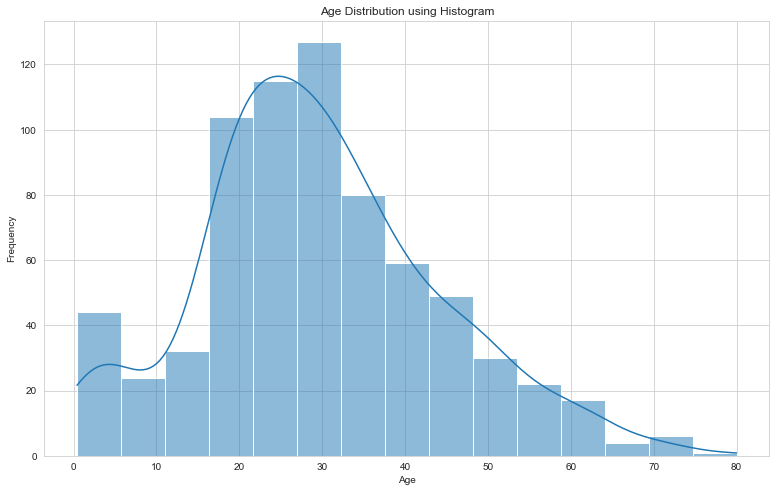

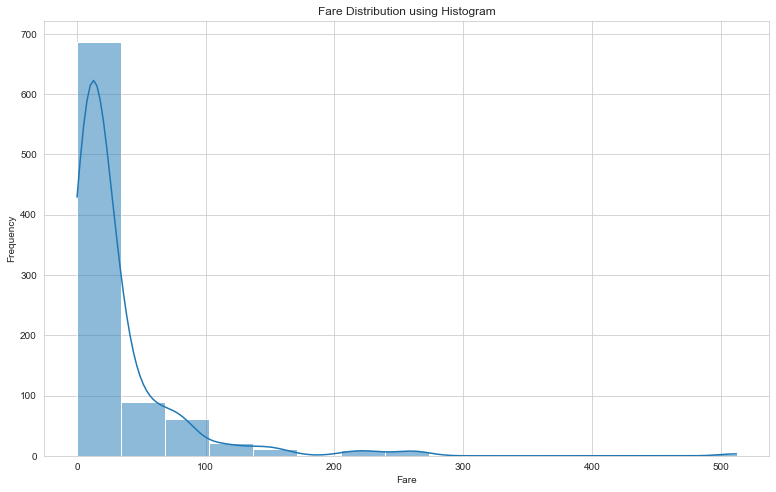

In [33]:
for c in NUMERICAL_VARIABLES:
    hist_plot(c, n_data, bins=15)

We'll also go ahead and impute some data using the `MeanMedianImputer` class, and see how that effects the histogram:

In [14]:
median_imputation = MeanMedianImputer(imputation_method='median', variables=NUMERICAL_VARIABLES)
imputed_n_data = median_imputation.fit_transform(n_data)
imputed_n_data["fare"] = imputed_n_data["fare"].replace(0, imputed_n_data['fare'].median())
imputed_n_data.head()

,age,fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500


In [15]:
imputed_n_data.describe()

,age,fare
count,891.000000,891.000000
mean,29.361582,32.447545
std,13.019697,49.570235
min,0.420000,4.012500
25%,22.000000,7.925000
50%,28.000000,14.454200
75%,35.000000,31.000000
max,80.000000,512.329200


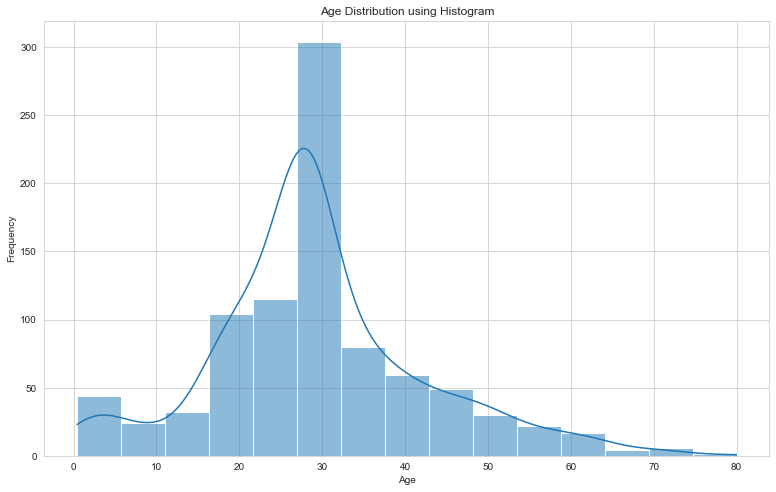

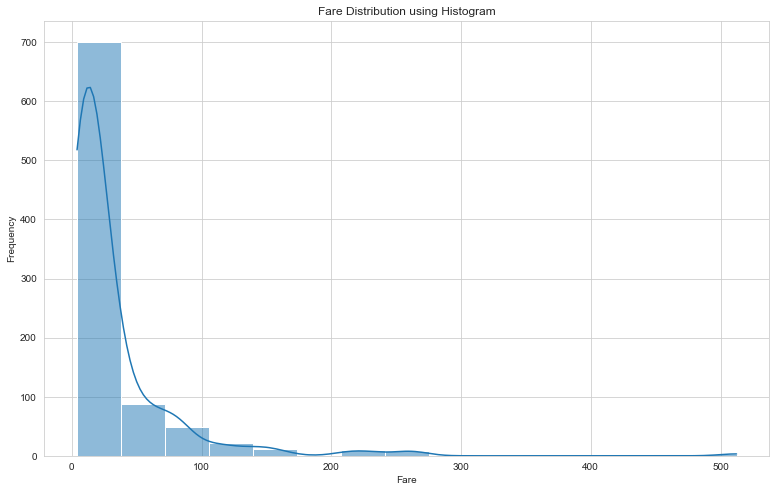

In [34]:
for c in NUMERICAL_VARIABLES:
    hist_plot(c, imputed_n_data, bins=15)

We won't really know how effective this was without more testing, however what may be a better idea is to impute using a linear regression based off of the different variables. The may have been an unintentional bias introduced by changing the data in this way.

Lets move onto using box and whiskers plots to get a better idea of how the distribution looks:

In [35]:
def box_plot(variable, df, whis=1.5):
    plt.figure(figsize = (13,8))
    sns.boxplot(data=df[variable], whis=1.5)
    plt.xlabel(variable)
    plt.title("{} Boxplot".format(variable.title()))
    plt.show()

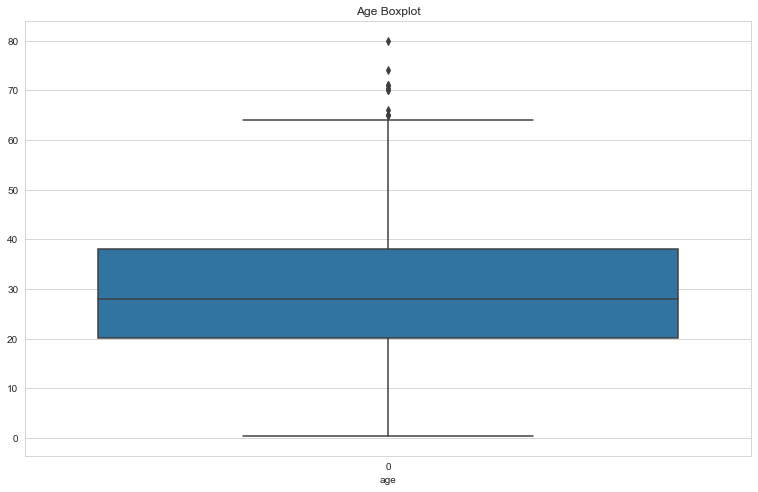

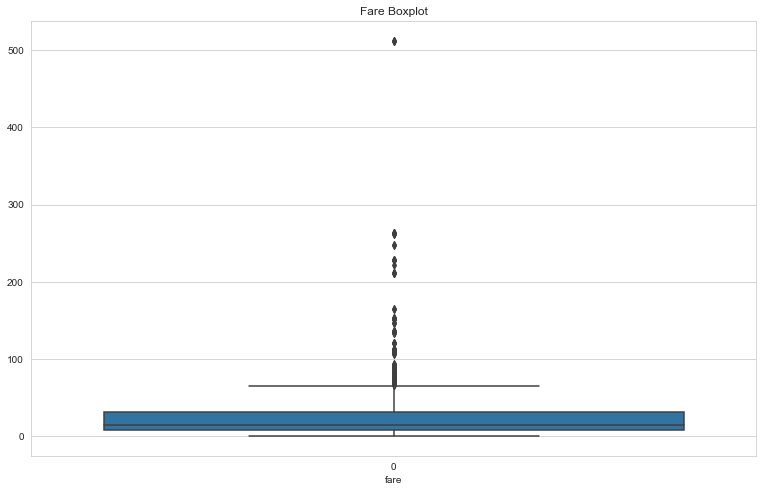

In [36]:
for c in NUMERICAL_VARIABLES:
    box_plot(c, n_data)

We can see there are definitely many outliers, and it may be worth changing the IQR variable that's being used here. According to the [`boxplot` documentation](https://seaborn.pydata.org/generated/seaborn.boxplot.html#seaborn-boxplot), the IQR is set with the `whis` parameter and the default is 1.5. This value may be to restrictive given the variance of the data.

Now that we have a better understanding of the data, lets take a look at how certain variables relate to one another [(x)](https://www.kaggle.com/mertyalcindag/titanic-eda#Basic-Data-Analysis):

In [19]:
# Pclass vs Survived
data[["pclass", "survived"]].groupby(["pclass"], as_index=False).mean().sort_values(by="pclass")

,pclass,survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [20]:
# Sex vs Survived
data[["sex", "survived"]].groupby(["sex"], as_index = False).mean().sort_values(by="sex")

,sex,survived
0,female,0.742038
1,male,0.188908


In [21]:
# Parch vs Survived
data[["parch", "survived"]].groupby(["parch"], as_index = False).mean().sort_values(by="parch")

,parch,survived
0,0,0.343658
1,1,0.550847
2,2,0.500000
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000


In [22]:
#SibSp vs Survived
data[["sibsp", "survived"]].groupby(["sibsp"], as_index = False).mean().sort_values(by="sibsp")

,sibsp,survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


From this, we can see a couple of things immediately:
- **Pclass vs Survived** - we can see that a higher proportion of people who are in a higher class survived than in a lower class
- **Sex vs Survived** - more woman survived than men, which is expected considering we save woman and children first
- **Parch vs Survived** - This is particularly interesting, and it will become clearer in the next section, but the 3, 4, 5, and 6 parents/children have at most 5 people in them, so there isn't too much to draw from this since we don't have enough samples to make a meaningful conclusion. There are far more passengers with 0, 1, and 2 parents/children on board, it seems that a higher proportion of passengers with at least 1 parent/child on board survived. I think this also makes sense, as again we typically save women and children first. Once again, those with 3+ parents/children on board are very few, and perhaps what may be better is to change the granularity of this category and bin the higher values together
- **SibSp vs Survived** - a very similar analysis can be made from above, there aren't very many instances of people with more than 2 siblings, and so it's hard to draw any meaningful information. It is understandable, however, that those with at least one or two siblings have a higher proportion of survivors since there *could* be an assumption made that it's because they are younger children, however it is still ambigious.

## **Categorial Data Exploration**
Lets go ahead and look at only the categorical data:

In [23]:
c_data = data[CATEGORICAL_VARIABLES]
c_data.head()

,pclass,sex,embarked,sibsp,parch,survived,cabin
0,3,male,S,1,0,0,NaN
1,1,female,C,1,0,1,C85
2,3,female,S,0,0,1,NaN
3,1,female,S,1,0,1,C123
4,3,male,S,0,0,0,NaN


In [24]:
c_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   pclass    891 non-null    int64 
 1   sex       891 non-null    object
 2   embarked  889 non-null    object
 3   sibsp     891 non-null    int64 
 4   parch     891 non-null    int64 
 5   survived  891 non-null    int64 
 6   cabin     204 non-null    object
dtypes: int64(4), object(3)
memory usage: 48.9+ KB


So we can see above, we have some values missing for `embarked` is missing only 2 which is pretty inconsequential. There is a pretty big problem with the `cabin` column though: almost 80% of the values are N/A! It will be incredibly difficult to extract any meaningful information from this, so we'll leave it for now. We do have a problem though... since the `sex` and `embarked` categories are `objects`, we need to convert them into categorical data instead:

In [25]:
CATEGORICAL_VARIABLES

['pclass', 'sex', 'embarked', 'sibsp', 'parch', 'survived', 'cabin']

In [26]:
sex_map = dict(zip(c_data["sex"].unique(), range(c_data["sex"].nunique())))
emb_map = dict(zip(c_data["embarked"].unique(), range(c_data["embarked"].nunique())))

c_data_no_cabin = c_data.drop(columns="cabin")
c_data_no_cabin["sex"] = c_data_no_cabin["sex"].map(sex_map)
c_data_no_cabin["embarked"] = c_data_no_cabin["embarked"].map(emb_map, na_action="ignore")

In [27]:
c_data_no_cabin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    891 non-null    int64  
 1   sex       891 non-null    int64  
 2   embarked  889 non-null    float64
 3   sibsp     891 non-null    int64  
 4   parch     891 non-null    int64  
 5   survived  891 non-null    int64  
dtypes: float64(1), int64(5)
memory usage: 41.9 KB


Now that we've converted the data into a more usable format, we'll go ahead and use a bar plot to see the distribution of the variables. We'll use the `hue` parameter to see how it looks based off of whether the passenger survived or not:

In [28]:
def bar_plot(variable, df, hue=None):
   """
      Taken from: https://www.kaggle.com/mertyalcindag/titanic-eda#Categorical-Variable
      
      input: Variable ex:"Sex"
      output: bar plot & value count
   """

   var = df[variable] # get feature
   varValue = var.value_counts() # count number of categorical variable

   # visualize
   plt.figure(figsize = (11,5))
   sns.barplot(x=varValue.index, y=varValue, palette="Blues_d", hue=hue)

   plt.ylabel("Frequency")
   plt.title(variable.title())
   plt.show()
   print("{}: {}".format(variable,varValue)) 
    

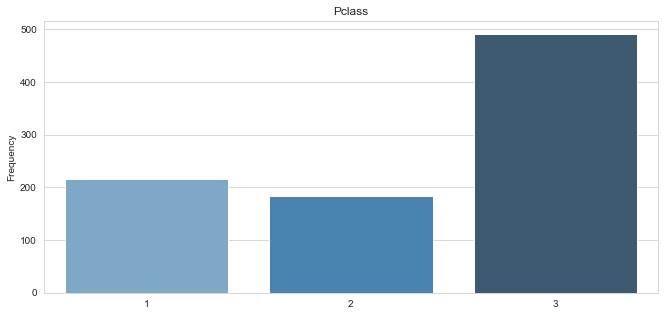

pclass: 3    491
1    216
2    184
Name: pclass, dtype: int64


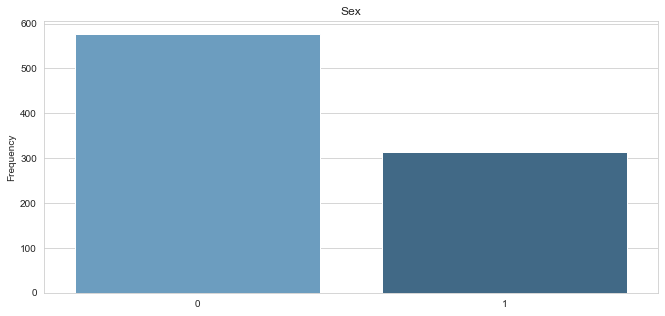

sex: 0    577
1    314
Name: sex, dtype: int64


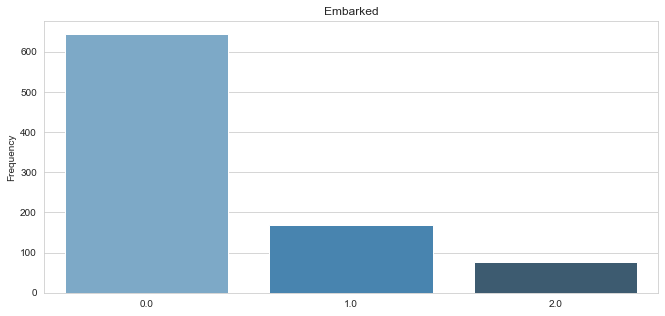

embarked: 0.0    644
1.0    168
2.0     77
Name: embarked, dtype: int64


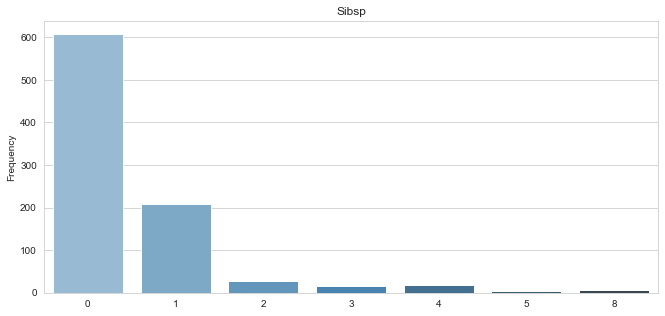

sibsp: 0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: sibsp, dtype: int64


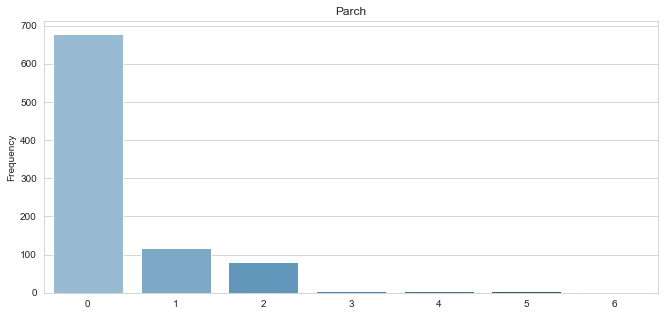

parch: 0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: parch, dtype: int64


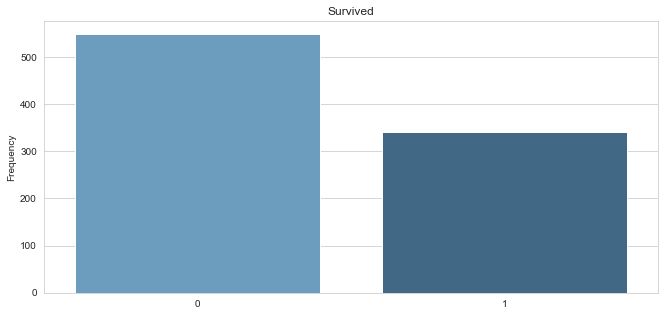

survived: 0    549
1    342
Name: survived, dtype: int64


In [29]:
for c in CATEGORICAL_VARIABLES[:-1]:
    bar_plot(c, c_data_no_cabin)

We can see here that there are definitely some imbalances in the data, with some features only having one instance, like `parch`. For some of these columns, we may have to take care of by using **stratified sampling** during our prediction phase, however for the instances like the `parch` we likely have to drop the instance all together, and acknowledge that our model will not be able to predict using this kind of data.



Last thing I'd like to explore very quickly is the correlation between the variables. Lets put together all of the changes we made and compare:

In [30]:
data["fare"] = n_data['fare']
data["age"] = n_data['age']
data["sex"] = c_data_no_cabin["sex"]
data["embarked"] = c_data_no_cabin["embarked"]

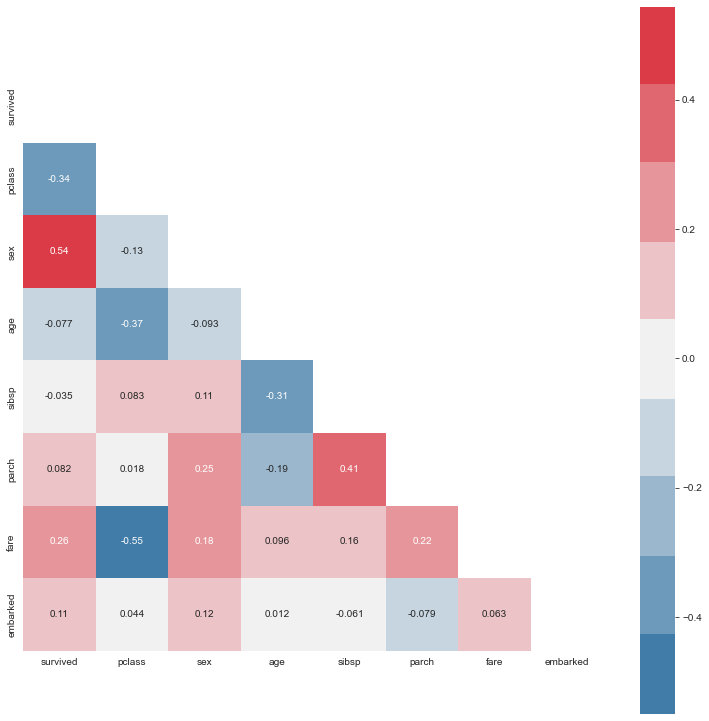

In [31]:
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
data_no_pid = data.drop(columns="passengerid")
data_corr = data_no_pid.corr()
mask = np.triu(np.ones_like(data_corr, dtype=bool))
palette = sns.diverging_palette(240, 10, n=9)

plt.figure(figsize=(13,13))
sns.heatmap(data_corr, mask=mask, center=0,
            square=True, cmap=palette, annot=True)
plt.show()

Looking at this, we can see a lot more clearly what values are more correlated with survival, and it seems the highest correlation we see regarding whether a passenger survived or not is the `sex`. Other noteworthy correlations are `(fare, survived)`, `(parch, sibsp)`, `(pclass, fare)` `(pclass, age)` , and `(pclass, age)`.

We'll keep this in mind when doing predictions during stage 2!

## **Summary**
There's some things that are immediately clear from this analysis. 
- The data is pretty lopsided
- There are a lot of missing values
- There seems to be some outliers that are important (i.e. maximum age being 80) and others that seem like mistakes in the data (i.e. minimum fare being $0). It's possible that there are people who were able to get on for free, however there's more research to be done to see if this was a possibility for the titanic.

For the prediction portion during stage 2, I'll try and address these issues to for better prediction results.